In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.linear_model
import matplotlib.patches as mpatches

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("recruitmentdataset-2022-1.3.csv")

In [60]:
D_data = data[(data['company'] == 'D') & (data['sport'].isin(['Swimming', 'Football', 'Golf']))]
D_data = D_data.drop(columns=['company','Id'])
D_data.info()
D_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 3000 to 3999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 474 non-null    object
 1   age                    474 non-null    int64 
 2   nationality            474 non-null    object
 3   sport                  474 non-null    object
 4   ind-university_grade   474 non-null    int64 
 5   ind-debateclub         474 non-null    bool  
 6   ind-programming_exp    474 non-null    bool  
 7   ind-international_exp  474 non-null    bool  
 8   ind-entrepeneur_exp    474 non-null    bool  
 9   ind-languages          474 non-null    int64 
 10  ind-exact_study        474 non-null    bool  
 11  ind-degree             474 non-null    object
 12  decision               474 non-null    bool  
dtypes: bool(6), int64(3), object(4)
memory usage: 32.4+ KB


,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,decision
3000,female,28,Dutch,Golf,65,False,False,True,False,1,False,phd,True
3001,female,22,Dutch,Football,70,False,True,False,False,1,True,master,True
3004,female,21,Dutch,Football,66,False,False,False,True,2,False,bachelor,True
3005,female,25,Dutch,Swimming,68,False,True,False,False,0,True,master,False
3006,male,31,Dutch,Football,67,False,True,False,False,2,True,master,True


# Data exploration

In [61]:
sns.set_style("whitegrid")
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7","#a57c1b"]
female_color = colors[7]
male_color = colors[1]
sns.set_palette(sns.color_palette(colors))

# hired_color = '#ffee65'
# unhired_color = '#beb9db'

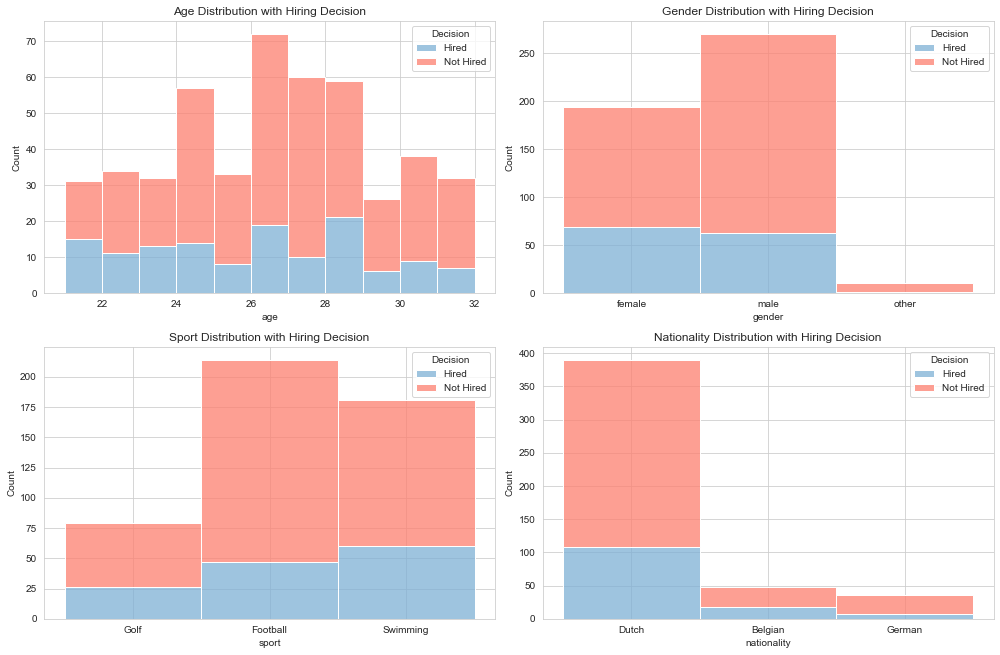

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
sns.histplot(data=D_data, x='age', hue='decision', multiple="stack", ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution with Hiring Decision')
axes[0, 0].legend(title='Decision', labels=['Hired', 'Not Hired'])
           
# gender distribution
sns.histplot(data=D_data, x='gender', hue='decision', multiple="stack", binwidth=1, ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution with Hiring Decision')
axes[0, 1].legend(title='Decision', labels=['Hired', 'Not Hired'])

# sport distribution
sns.histplot(data=D_data, x='sport',hue='decision', multiple="stack", bins=4, ax=axes[1, 0])
axes[1, 0].set_title('Sport Distribution with Hiring Decision')
axes[1, 0].legend(title='Decision', labels=['Hired', 'Not Hired'])

# Nationality Distribution
sns.histplot(data=D_data, x='nationality', hue='decision', multiple="stack", ax=axes[1, 1])
axes[1, 1].set_title('Nationality Distribution with Hiring Decision')
axes[1, 1].legend(title='Decision', labels=['Hired', 'Not Hired'])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

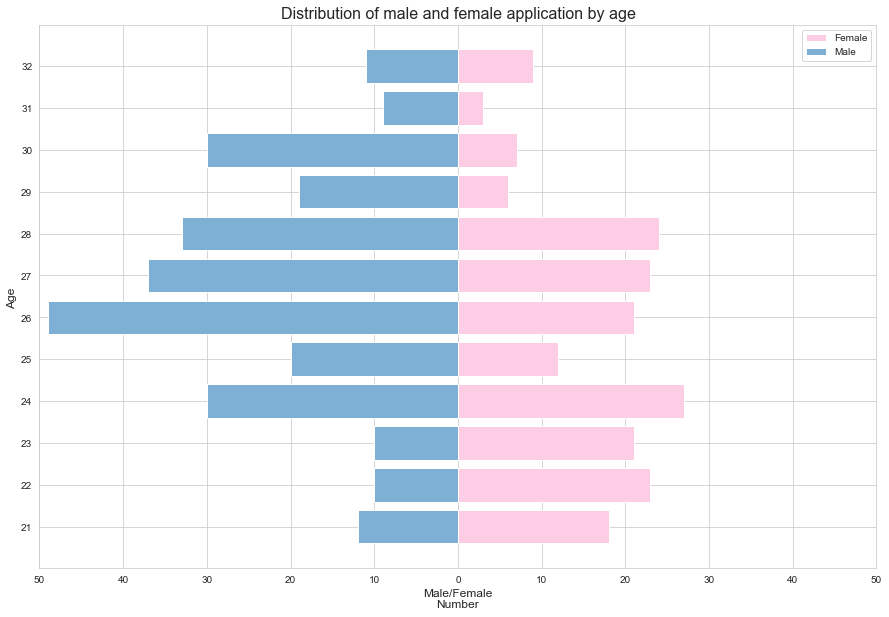

In [63]:
#AGE BY GENDER
age = [21, 22,23,24,25,26,27,28,29,30,31,32]
male = [0,0,0,0,0,0,0,0,0,0,0,0]
female = [0,0,0,0,0,0,0,0,0,0,0,0]

for i in age:
    for ind in D_data.index:
        if(i == D_data['age'][ind]):
            if (D_data['gender'][ind] == 'female'): female[i-21] +=1
            elif (D_data['gender'][ind] == 'male'): male[i-21] +=1


population_df = pd.DataFrame({"Age": age, "Male": male, "Female": female})
population_df["Female_Left"] = 0
population_df["Female_Width"] = population_df["Female"]
population_df["Male_Left"] = -population_df["Male"]
population_df["Male_Width"] = population_df["Male"]

fig = plt.figure(figsize=(15,10))

plt.barh(y=population_df["Age"], width=population_df["Female_Width"], color=female_color, label="Female");
plt.barh(y=population_df["Age"], width=population_df["Male_Width"], left=population_df["Male_Left"],
         color=male_color, label="Male")

ax1 = plt.subplot()
ax1.set_yticks(population_df["Age"])
plt.xticks(ticks=[-50, -40,-30,-20,-10, 0,10,20, 30,40 ,50],
labels=['50', '40', '30' ,'20','10', '0','10','20', '30','40', '50'])
plt.legend(loc="best");
plt.xlabel("Male/Female\nNumber", fontsize=12)
plt.ylabel("Age ",fontsize = 12)
plt.title("Distribution of male and female application by age", fontsize=16)
plt.show()

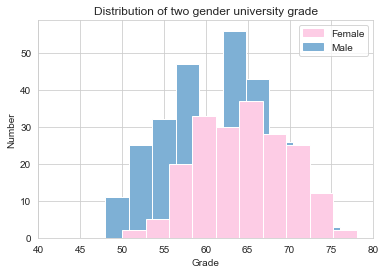

In [64]:
#Male vs female:
pink_patch = mpatches.Patch(color=female_color, label='Female')
blue_patch = mpatches.Patch(color=male_color, label='Male')

plt.hist(D_data[D_data['gender'] == 'male']['ind-university_grade'],  color = male_color)
plt.hist(D_data[D_data['gender'] == 'female']['ind-university_grade'],  color = female_color)

plt.title('Distribution of two gender university grade')
plt.xlabel('Grade')
plt.ylabel('Number')
plt.legend(handles=[pink_patch, blue_patch])
plt.xlim(left=40, right = 80)
plt.show()

I don't think this one is helpful, female bars covered male's.

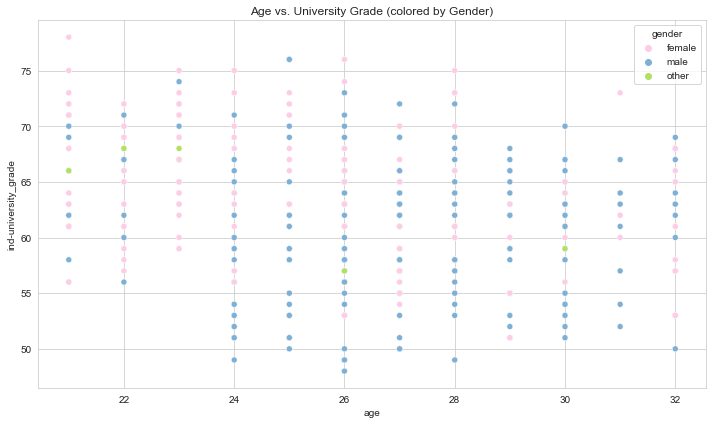

In [65]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=D_data, x='age', y='ind-university_grade', hue='gender', marker='o', palette=[female_color, male_color, '#b2e061'])
plt.title('Age vs. University Grade (colored by Gender)')

plt.tight_layout()
plt.show()

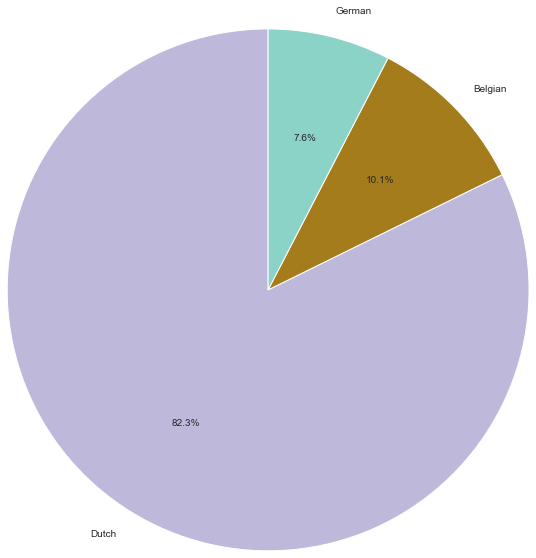

In [66]:
#Nationality ratio
country_count = D_data['nationality'].nunique()
country_count_series = D_data['nationality'].value_counts()
countries = []
count_country = []
for country, freq in country_count_series.iteritems():
        countries.append(country)
        count_country.append(freq)
plt.pie(count_country,labels=countries, startangle=90, autopct='%1.1f%%',radius=3, colors=["#beb9db","#a57c1b", "#8bd3c7"])
plt.show()

nice one, but we have one as histogram, i don't if we can put pie chart as this is not required.

In [67]:
min_max_values = D_data.agg({
    'age': ['min', 'max'],
    'ind-university_grade': ['min', 'max'],
    'ind-languages': ['min', 'max']
})

min_max_values.rename(index={'min': 'Minimum', 'max': 'Maximum'}, inplace=True)
min_max_values.columns = ['Age', 'University Grade', 'Number of Languages']
min_max_values

,Age,University Grade,Number of Languages
Minimum,21,48,0
Maximum,32,78,3


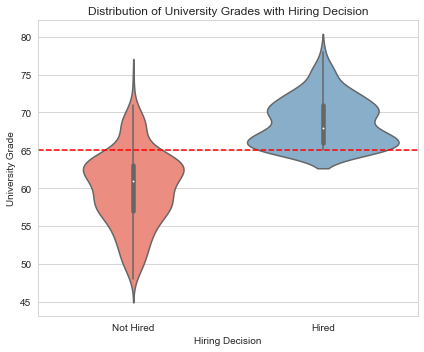

In [68]:
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(6, 5))

sns.violinplot(data=D_data, x='decision', y='ind-university_grade')
plt.title('Distribution of University Grades with Hiring Decision')
plt.xlabel("Hiring Decision")
plt.ylabel("University Grade")
plt.xticks(ticks=[False, True], labels=['Not Hired', 'Hired'])
plt.axhline(y=65, color='r', linestyle='--', label='y=65')

plt.tight_layout()
plt.show()

- The median grade of hired candidates is visibly higher than that of non-hired candidates. The minimum grade requirement >=65 in relation to hiring decisions.

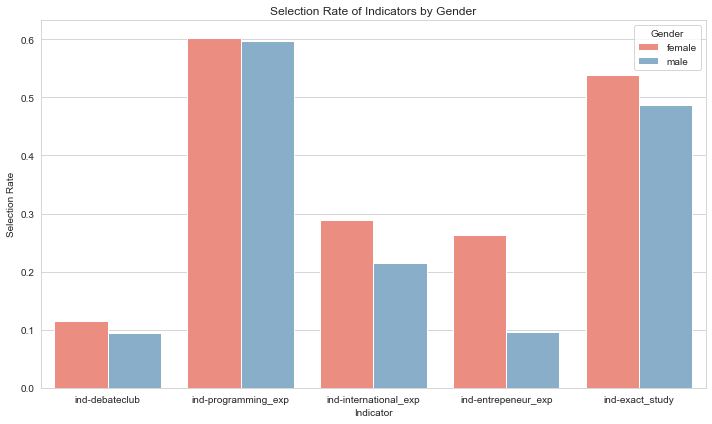

In [69]:
gender_data = D_data[D_data['gender'].isin(['female', 'male'])]

indicators = [
    'ind-debateclub',
    'ind-programming_exp',
    'ind-international_exp',
    'ind-entrepeneur_exp',
    'ind-exact_study'
]

# Calculate selection rates for each indicator and gender
selection_rates_gender = pd.DataFrame()

for ind in indicators:
    rates = gender_data[gender_data[ind] == True].groupby('gender')['decision'].mean().reset_index()
    rates['indicator'] = ind
    selection_rates_gender = pd.concat([selection_rates_gender, rates], axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(data=selection_rates_gender, x='indicator', y='decision', hue='gender')
plt.title('Selection Rate of Indicators by Gender')
plt.xlabel('Indicator')
plt.ylabel('Selection Rate')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

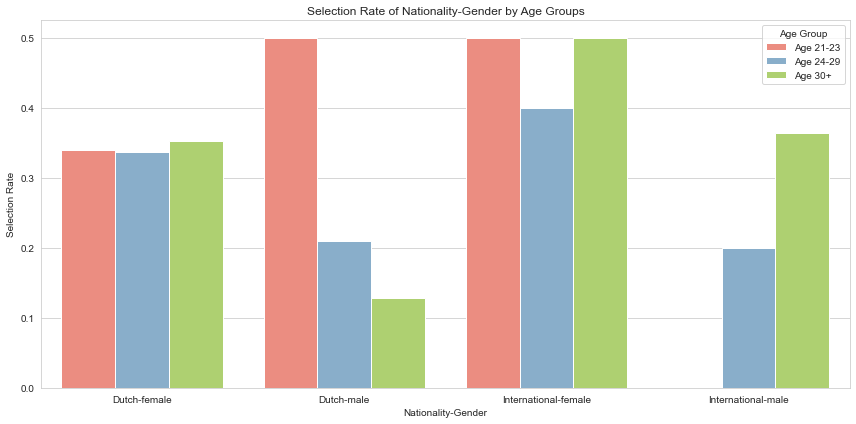

In [70]:
bins = [47, 64, 69, 100] 
labels = ['Grade 48-64', 'Grade 65-69', 'Grade 70+']
D_data['grade_group'] = pd.cut(D_data['ind-university_grade'], bins=bins, labels=labels, right=True)

bins = [20, 23, 29, 100]  
labels = ['Age 21-23', 'Age 24-29', 'Age 30+']
D_data['age_group'] = pd.cut(D_data['age'], bins=bins, labels=labels, right=True)

# Simplify nationality and filter data for specified genders
D_data['simple_nationality'] = D_data['nationality'].apply(lambda x: 'Dutch' if x == 'Dutch' else 'International')
filtered_data = D_data[D_data['gender'].isin(['female', 'male'])].copy()  # Creating a copy to avoid warnings

filtered_data['nationality_gender'] = filtered_data['simple_nationality'] + '-' + filtered_data['gender']

selection_rates_natgen_age = filtered_data.groupby(['nationality_gender', 'age_group'])['decision'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_natgen_age, x='nationality_gender', y='decision', hue='age_group', ci=None)
plt.title('Selection Rate of Nationality-Gender by Age Groups')
plt.xlabel('Nationality-Gender')
plt.ylabel('Selection Rate')
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

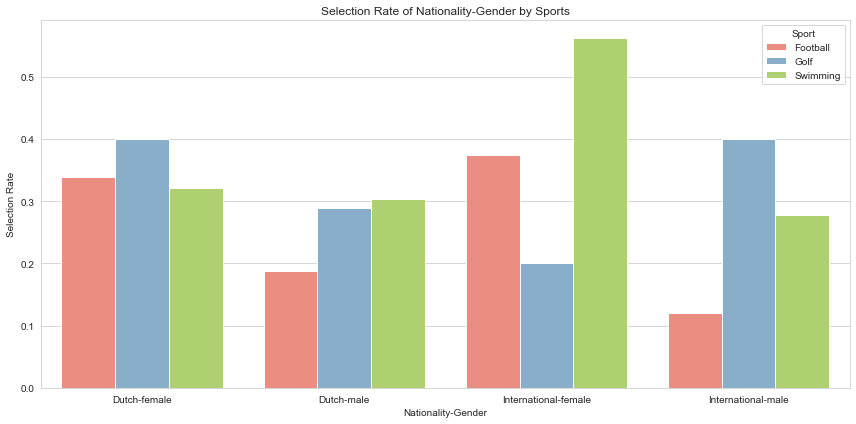

In [71]:
selection_rates_natgen_sport = filtered_data.groupby(['nationality_gender', 'sport'])['decision'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_natgen_sport, x='nationality_gender', y='decision', hue='sport', ci=None)
plt.title('Selection Rate of Nationality-Gender by Sports')
plt.xlabel('Nationality-Gender')
plt.ylabel('Selection Rate')
plt.legend(title='Sport')
plt.tight_layout()
plt.show()


## Comparison of Selection rates of Subgroups

In [72]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 3000 to 3999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gender                 464 non-null    object  
 1   age                    464 non-null    int64   
 2   nationality            464 non-null    object  
 3   sport                  464 non-null    object  
 4   ind-university_grade   464 non-null    int64   
 5   ind-debateclub         464 non-null    bool    
 6   ind-programming_exp    464 non-null    bool    
 7   ind-international_exp  464 non-null    bool    
 8   ind-entrepeneur_exp    464 non-null    bool    
 9   ind-languages          464 non-null    int64   
 10  ind-exact_study        464 non-null    bool    
 11  ind-degree             464 non-null    object  
 12  decision               464 non-null    bool    
 13  grade_group            464 non-null    category
 14  age_group              464 non-null   

In [73]:
# Create subgroups
filtered_data['nationality_gender_prog'] = filtered_data['nationality_gender'] + '&' + filtered_data['ind-programming_exp'].apply(lambda x: 'programming' if x else 'non-programming')
filtered_data['nationality_gender_exact'] = filtered_data['nationality_gender'] + '&' + filtered_data['ind-exact_study'].apply(lambda x: 'exact study' if x else 'non-exact_study')
filtered_data['nationality_gender_grade'] = filtered_data['nationality_gender'] + '&' + filtered_data['grade_group'].astype(str)
filtered_data['nationality_gender_degree'] = filtered_data['nationality_gender']  + '&' + filtered_data['ind-degree'].astype(str)
filtered_data['nationality_gender_sport']  = filtered_data['nationality_gender']  + '&' + filtered_data['sport'].astype(str)

filtered_data['age_prog'] = filtered_data['age_group'].astype(str) + '&' + filtered_data['ind-programming_exp'].apply(lambda x: 'programming' if x else 'non-programming')
filtered_data['age_exact'] = filtered_data['age_group'].astype(str) + '&' + filtered_data['ind-exact_study'].apply(lambda x: 'exact study' if x else 'non-exact_study')
filtered_data['age_grade'] = filtered_data['age_group'].astype(str) + '&' + filtered_data['grade_group'].astype(str)
filtered_data['age_degree'] = filtered_data['age_group'].astype(str) + '&' + filtered_data['ind-degree'].astype(str)

filtered_data = filtered_data.drop(columns=['gender', 'age', 'nationality' ,'simple_nationality', 
                                            'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp'])
filtered_data.columns.tolist()

['sport',
 'ind-university_grade',
 'ind-programming_exp',
 'ind-languages',
 'ind-exact_study',
 'ind-degree',
 'decision',
 'grade_group',
 'age_group',
 'nationality_gender',
 'nationality_gender_prog',
 'nationality_gender_exact',
 'nationality_gender_grade',
 'nationality_gender_degree',
 'nationality_gender_sport',
 'age_prog',
 'age_exact',
 'age_grade',
 'age_degree']

In [74]:
subgroup_list = [
    'nationality_gender_prog', 
    'nationality_gender_exact', 
    'nationality_gender_grade', 
    'nationality_gender_degree', 
    'nationality_gender_sport',
    'age_prog',
    'age_exact',
    'age_grade',
    'age_degree'
]

subgroup_summary_corrected = pd.DataFrame(columns=['Subgroup', 'Total', 'Selected', 'Rate%'])

# Recalculate metrics for each subgroup
for subgroup in subgroup_list:
    # Group by the subgroup and calculate metrics
    subgroup_data = filtered_data.groupby(subgroup)['decision'].agg(['count', 'sum']).reset_index()
    subgroup_data['Rate%'] = round((subgroup_data['sum'] / subgroup_data['count'] * 100),2)
    
    subgroup_data.columns = ['Subgroup', 'Total', 'Selected', 'Rate%']
    
    subgroup_summary_corrected = pd.concat([subgroup_summary_corrected, subgroup_data], ignore_index=True)

subgroup_summary_corrected = subgroup_summary_corrected.sort_values(by=['Rate%'], ascending=False)

subgroup_summary_corrected.head(20)  


,Subgroup,Total,Selected,Rate%
27,International-male&Grade 70+,3,3,100.0
75,Age 21-23&phd,2,2,100.0
72,Age 30+&Grade 70+,4,4,100.0
24,International-female&Grade 70+,7,7,100.0
66,Age 21-23&Grade 70+,29,27,93.1
18,Dutch-female&Grade 70+,32,29,90.62
69,Age 24-29&Grade 70+,30,26,86.67
71,Age 30+&Grade 65-69,14,12,85.71
21,Dutch-male&Grade 70+,21,18,85.71
5,International-female&programming,15,12,80.0


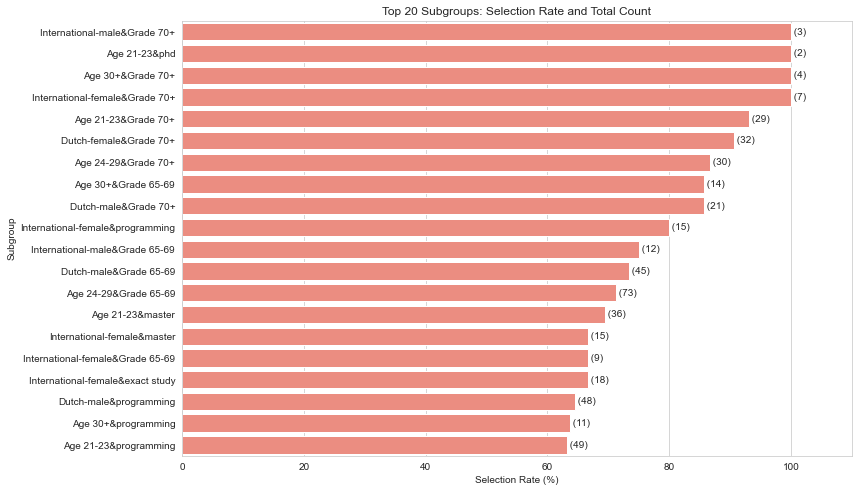

In [75]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Rate%', y='Subgroup', data=subgroup_summary_corrected.head(20), color=colors[0])

# Scatter plot for 'Total' values
for i, total in enumerate(subgroup_summary_corrected.head(20)['Total']):
    plt.text(subgroup_summary_corrected.head(20).iloc[i]['Rate%'], i, f" ({int(total)})", va='center')

plt.title('Top 20 Subgroups: Selection Rate and Total Count')
plt.xlabel('Selection Rate (%)')
plt.ylabel('Subgroup')
plt.xlim([0, subgroup_summary_corrected['Rate%'].max() + 10])  # Adjust limit to accommodate text

plt.show()



# Model with subgroups

input:
1. 'sport'
2. 'ind-programming_exp',
3. 'ind-languages',
4. 'ind-exact_study',
5. 'ind-degree',
6. 'grade_group',
7. 'age_group',
8. 'nationality_gender'

In [76]:
# Using get_dummies for One-Hot Encoding 
filtered_data_encoded = pd.get_dummies(filtered_data, columns=['nationality_gender', 'sport','age_group','grade_group'], prefix='', prefix_sep='')

# Integer Encoding for 'ind-degree' column
degree_mapping = {'bachelor': 0, 'master': 1, 'phd': 2}
filtered_data_encoded['ind-degree'] = filtered_data_encoded['ind-degree'].map(degree_mapping)

filtered_data_encoded = filtered_data_encoded.drop(columns=['nationality_gender_prog', 
                                                            'nationality_gender_exact', 
                                                              'nationality_gender_grade', 
                                                              'nationality_gender_degree', 
                                                              'nationality_gender_sport',
                                                              'age_prog',
                                                              'age_exact',
                                                              'age_grade',
                                                              'age_degree','ind-university_grade'])
filtered_data_encoded.head()

,ind-programming_exp,ind-languages,ind-exact_study,ind-degree,decision,Dutch-female,Dutch-male,International-female,International-male,Football,Golf,Swimming,Age 21-23,Age 24-29,Age 30+,Grade 48-64,Grade 65-69,Grade 70+
3000,False,1,False,2,True,1,0,0,0,0,1,0,0,1,0,0,1,0
3001,True,1,True,1,True,1,0,0,0,1,0,0,1,0,0,0,0,1
3004,False,2,False,0,True,1,0,0,0,1,0,0,1,0,0,0,1,0
3005,True,0,True,1,False,1,0,0,0,0,0,1,0,1,0,0,1,0
3006,True,2,True,1,True,0,1,0,0,1,0,0,0,0,1,0,1,0


In [77]:
filtered_data_encoded.columns.tolist()

['ind-programming_exp',
 'ind-languages',
 'ind-exact_study',
 'ind-degree',
 'decision',
 'Dutch-female',
 'Dutch-male',
 'International-female',
 'International-male',
 'Football',
 'Golf',
 'Swimming',
 'Age 21-23',
 'Age 24-29',
 'Age 30+',
 'Grade 48-64',
 'Grade 65-69',
 'Grade 70+']

In [79]:
X = filtered_data_encoded.drop(columns=['decision'])
y = filtered_data_encoded['decision']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42,
                                                    stratify=y)

# hyperparameters tuning
param_grid = {
    'max_depth': np.arange(2, 18, 1),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(2, 18, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)
0.8946274098572236


## Model 1

In [80]:
# all input
X = filtered_data_encoded.drop(columns=['decision'])
y = filtered_data_encoded['decision']

X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(X, y, test_size=.4, random_state = 42,
                                                    stratify=y)

model_one = DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)

model_one.fit(X_train_one, y_train_one)
predictions = model_one.predict(X_test_one) 
f1 = f1_score(y_test_one, predictions, average='weighted')
print(classification_report(y_test_one, predictions))

              precision    recall  f1-score   support

       False       0.99      0.95      0.97       133
        True       0.88      0.98      0.93        53

    accuracy                           0.96       186
   macro avg       0.94      0.96      0.95       186
weighted avg       0.96      0.96      0.96       186



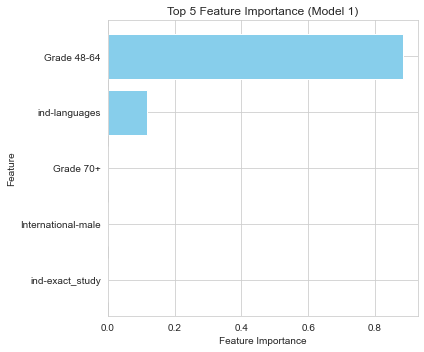

In [81]:
def plot_top_features(model, feature_names, top_n, title):

    feature_importance = model.feature_importances_
    
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]
    
    # Select the top N most important features
    top_importance = sorted_importance[:top_n]
    top_feature_names = sorted_feature_names[:top_n]
    
    plt.barh(range(len(top_importance)), top_importance, align='center', color='skyblue')
    plt.yticks(range(len(top_importance)), top_feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(title)
    plt.gca().invert_yaxis() 

plt.figure(figsize=(6, 5))

plot_top_features(model_one, X_train_one.columns, top_n=5, title="Top 5 Feature Importance (Model 1)")

plt.tight_layout()
plt.show()


# Model without subgroups (original data)

In [82]:
# Using get_dummies for One-Hot Encoding and keeping original column names
D_data_encoded = pd.get_dummies(D_data, columns=['gender', 'nationality', 'sport'], prefix=['', '', ''], prefix_sep='')

# Integer Encoding for 'ind-degree' column
degree_mapping = {'bachelor': 0, 'master': 1, 'phd': 2}
D_data_encoded['ind-degree'] = D_data_encoded['ind-degree'].map(degree_mapping)

D_data_encoded = D_data_encoded.drop(columns=['age_group', 'grade_group', 'simple_nationality' , 'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp'])


D_data_encoded.head()

,age,ind-university_grade,ind-programming_exp,ind-languages,ind-exact_study,ind-degree,decision,female,male,other,Belgian,Dutch,German,Football,Golf,Swimming
3000,28,65,False,1,False,2,True,1,0,0,0,1,0,0,1,0
3001,22,70,True,1,True,1,True,1,0,0,0,1,0,1,0,0
3004,21,66,False,2,False,0,True,1,0,0,0,1,0,1,0,0
3005,25,68,True,0,True,1,False,1,0,0,0,1,0,0,0,1
3006,31,67,True,2,True,1,True,0,1,0,0,1,0,1,0,0


In [83]:
D_data_encoded.columns.tolist()

['age',
 'ind-university_grade',
 'ind-programming_exp',
 'ind-languages',
 'ind-exact_study',
 'ind-degree',
 'decision',
 'female',
 'male',
 'other',
 'Belgian',
 'Dutch',
 'German',
 'Football',
 'Golf',
 'Swimming']

## Model 2

In [84]:
X = D_data_encoded.drop(columns=['decision'])
y = D_data_encoded['decision']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

# hyperparameters tuning
param_grid = {
    'max_depth': np.arange(2, 18, 1),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(2, 18, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=8,
                       random_state=42)
0.912492907848945


In [85]:
#Input 1
X = D_data_encoded.drop(columns=['decision'])
y = D_data_encoded['decision']


X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model_two = DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=8, random_state=42)

model_two.fit(X_train_two, y_train_two)
predictions = model_two.predict(X_test_two) 
print(classification_report(y_test_two, predictions))

              precision    recall  f1-score   support

       False       0.95      0.93      0.94       103
        True       0.83      0.88      0.85        40

    accuracy                           0.92       143
   macro avg       0.89      0.90      0.90       143
weighted avg       0.92      0.92      0.92       143



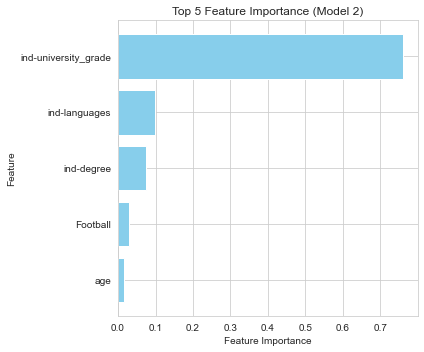

In [86]:
plt.figure(figsize=(6, 5))

plot_top_features(model_two, X_train_two.columns, top_n=5, title="Top 5 Feature Importance (Model 2)")

plt.tight_layout()
plt.show()


## Model 3: top 5 features

In [87]:
X = D_data_encoded[['ind-university_grade', 'ind-languages', 'ind-degree', 'age', 'Football']]
y = D_data_encoded['decision']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=9,
                       random_state=42)
0.9220417800293962


In [88]:
X = D_data_encoded[['ind-university_grade', 'ind-languages', 'ind-degree', 'age', 'Football' ]]
y = D_data_encoded['decision']

X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model_three = DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=9,
                       random_state=42)

model_three.fit(X_train_three, y_train_three)
predictions = model_three.predict(X_test_three) 
f1 = f1_score(y_test_three, predictions, average='weighted')
print(classification_report(y_test_three, predictions))

              precision    recall  f1-score   support

       False       0.96      0.93      0.95       103
        True       0.84      0.90      0.87        40

    accuracy                           0.92       143
   macro avg       0.90      0.92      0.91       143
weighted avg       0.93      0.92      0.92       143



# Model validation
- Show charts that show the performance differences that you get from different variations of input on a validation set. And hyperparameters.
- Using the carts, explain what input you choose and which hyperparameters.

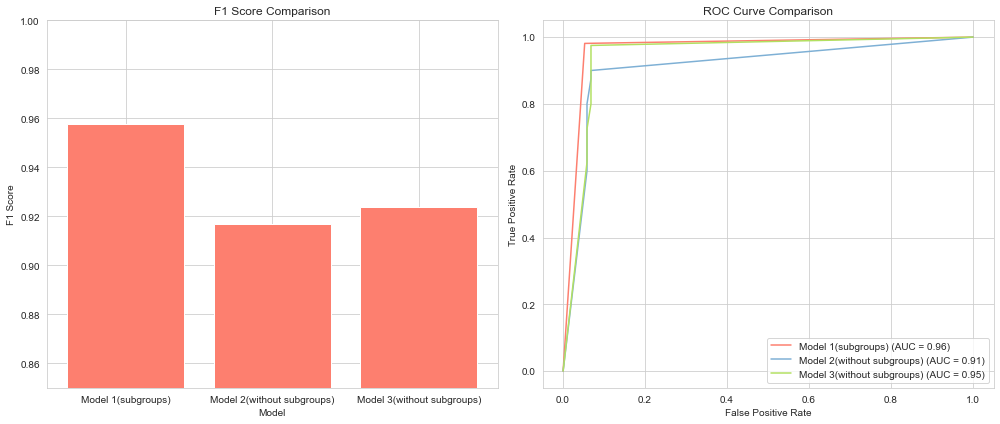

In [89]:
metrics = []

def calculate_metrics(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    predict_proba = model.predict_proba(X_test)[:, 1]
    f1 = f1_score(y_test, predictions, average='weighted')
    fpr, tpr, _ = roc_curve(y_test, predict_proba)
    roc_auc = auc(fpr, tpr)
    metrics.append((model_name, f1, fpr, tpr, roc_auc))

calculate_metrics(model_one, X_test_one, y_test_one, "Model 1(subgroups)")
calculate_metrics(model_two, X_test_two, y_test_two, "Model 2(without subgroups)")
calculate_metrics(model_three, X_test_three, y_test_three, "Model 3(without subgroups)")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar Chart for F1-Score
ax[0].bar([m[0] for m in metrics], [m[1] for m in metrics])
ax[0].set_xlabel('Model')
ax[0].set_ylabel('F1 Score')
ax[0].set_ylim(0.85, 1) 
ax[0].set_title('F1 Score Comparison')

# ROC Curves
for m in metrics:
    ax[1].plot(m[2], m[3], label=f'{m[0]} (AUC = {m[4]:.2f})')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve Comparison')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


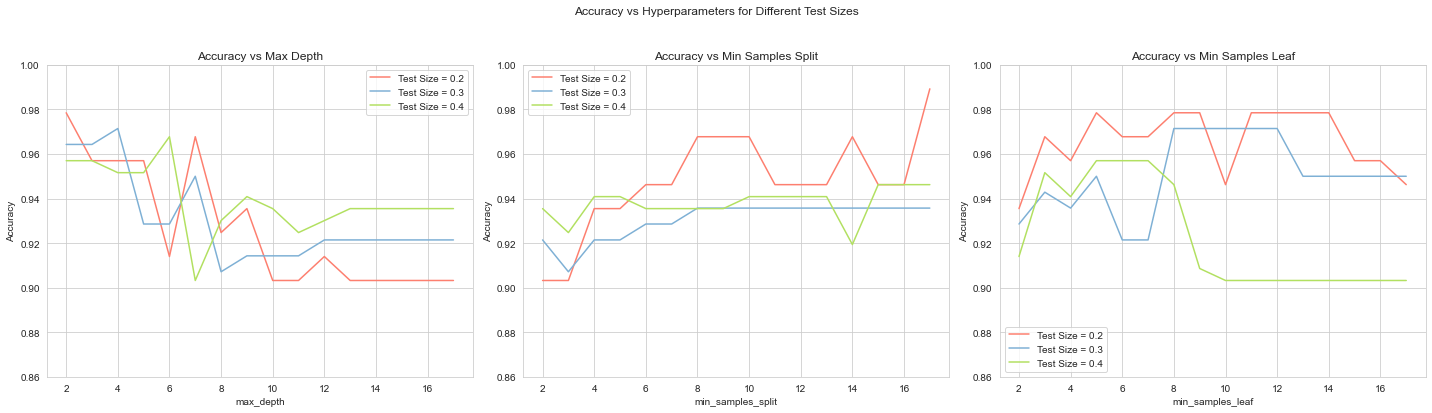

In [90]:
# X = D_data_encoded[['ind-university_grade', 'ind-languages', 'ind-degree', 'age', 'Football']]
# y = D_data_encoded['decision']

X = filtered_data_encoded.drop(columns=['decision'])
y = filtered_data_encoded['decision']

test_sizes = [0.2, 0.3, 0.4]

# Hyperparameters to be varied for analysis
hyperparam_values = {
    'max_depth': np.arange(2, 18, 1),
    'min_samples_split': np.arange(2, 18, 1),
    'min_samples_leaf': np.arange(2, 18, 1)
}

accuracy_results = {
    'max_depth': {size: [] for size in test_sizes},
    'min_samples_split': {size: [] for size in test_sizes},
    'min_samples_leaf': {size: [] for size in test_sizes}
}

for size in test_sizes:
    for param_name, param_values in hyperparam_values.items():
        for param_value in param_values:
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=size, random_state=42, stratify=y
            )
            
            # Initialize and train model
            model_params = {param_name: param_value}
            model = DecisionTreeClassifier(**model_params, random_state=42)
            model.fit(X_train, y_train)
            
            # Predict and calculate accuracy
            predictions = model.predict(X_test)
            acc = accuracy_score(y_test, predictions)
            
            # Store accuracy
            accuracy_results[param_name][size].append(acc)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Accuracy vs Hyperparameters for Different Test Sizes')

for ax, (param_name, acc_results) in zip(axs, accuracy_results.items()):
    for size, acc in acc_results.items():
        ax.plot(hyperparam_values[param_name], acc, label=f'Test Size = {size}')
    ax.set_xlabel(param_name)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.86, 1) 
    ax.legend()
    ax.grid(True)

axs[0].set_title('Accuracy vs Max Depth')
axs[1].set_title('Accuracy vs Min Samples Split')
axs[2].set_title('Accuracy vs Min Samples Leaf')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()